In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sagemaker
import boto3
import json
import math
import os
import sys
import scipy
import statsmodels
import seaborn as sns

In [2]:
bucket='cic-network-data'

In [3]:
file_path='abt.csv'

In [4]:
role=sagemaker.get_execution_role()

In [5]:
s3=boto3.resource('s3')

In [6]:
s3.Bucket(bucket).download_file(file_path, file_path)

In [6]:
df=pd.read_csv('./abt.csv')

In [7]:
df.shape

(16232943, 77)

In [8]:
df.head()

,Label,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Idle Mean,Idle Std,Idle Max,Idle Min,Hour,Minute,Second,Day,Month,Year
0,0,443,6,141385,9,7,553.0,3773.0,202.0,0.0,...,0.0,0.0,0.0,0.0,8,47,38,2,3,2018
1,0,49684,6,281,2,1,38.0,0.0,38.0,0.0,...,0.0,0.0,0.0,0.0,8,47,38,2,3,2018
2,0,443,6,279824,11,15,1086.0,10527.0,385.0,0.0,...,0.0,0.0,0.0,0.0,8,47,40,2,3,2018
3,0,443,6,132,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8,47,40,2,3,2018
4,0,443,6,274016,9,13,1285.0,6141.0,517.0,0.0,...,0.0,0.0,0.0,0.0,8,47,41,2,3,2018


In [9]:
df.columns.values

array(['Label', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg

In [10]:
flags = [ 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Fwd PSH Flags',
       'Fwd URG Flags']

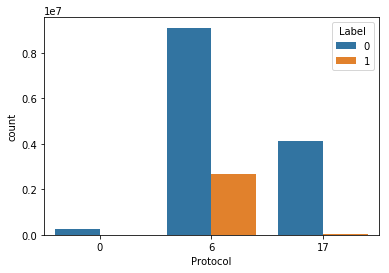

In [11]:
sns.countplot(x="Protocol", hue="Label", data=df)
plt.show()

In [12]:
flag_df = pd.melt(df[flags])

In [13]:
flag_df.head()

,variable,value
0,FIN Flag Cnt,0
1,FIN Flag Cnt,0
2,FIN Flag Cnt,0
3,FIN Flag Cnt,0
4,FIN Flag Cnt,0


In [14]:
flag_df.tail()

,variable,value
162329425,Fwd URG Flags,0
162329426,Fwd URG Flags,0
162329427,Fwd URG Flags,0
162329428,Fwd URG Flags,0
162329429,Fwd URG Flags,0


In [15]:
flag_df.variable.unique()

array(['FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Fwd PSH Flags', 'Fwd URG Flags'], dtype=object)

In [16]:
benign= df[df['Label'] == 0]
attack=df[df['Label'] == 1]

In [17]:
def graph_flags():
    for flag in flags:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(11,4))
        ax1=sns.countplot(x=flag, ax=ax1, data=attack)
        ax1.set(xlabel=flag + ' set - Attack')
        ax2=sns.countplot(x=flag, ax=ax2, data=benign)
        ax2.set(xlabel=flag + ' set - Benign')
        ax3=sns.countplot(x=flag, ax=ax3, data=df)
        ax3.set(xlabel=flag + ' set - All Traffic')

        plt.suptitle('Flags set Malicious Network Traffic vs Normal Network Traffic')
        plt.show()

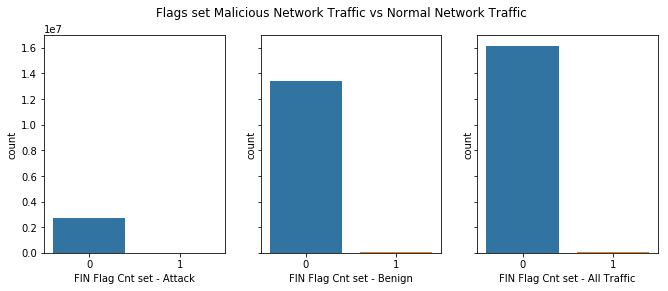

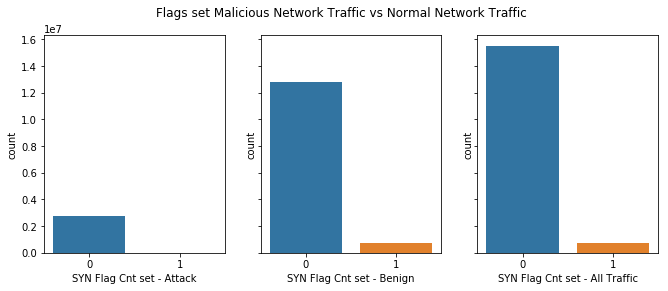

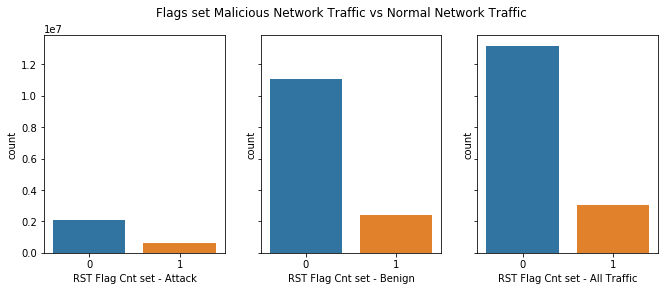

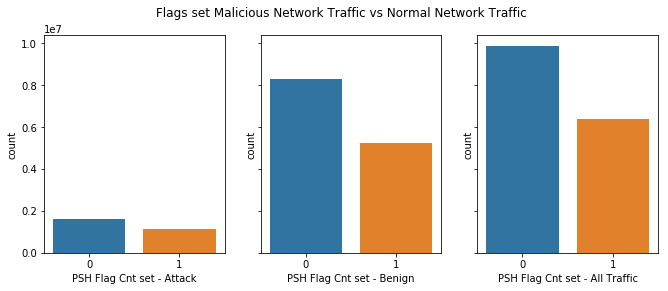

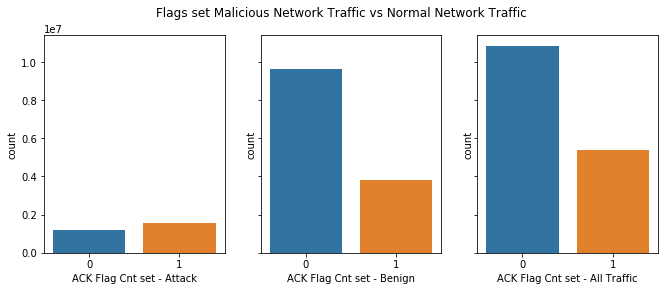

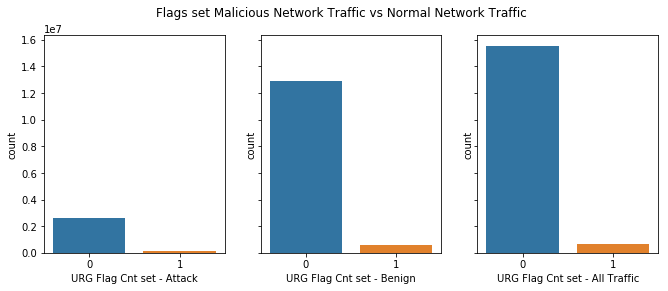

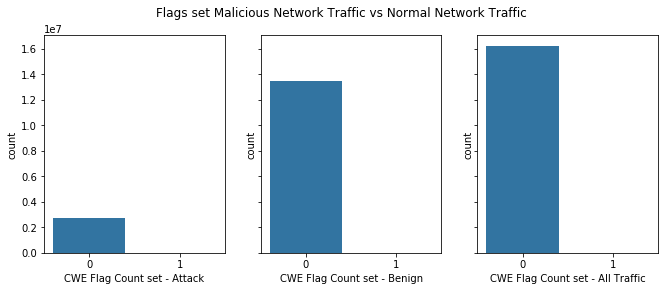

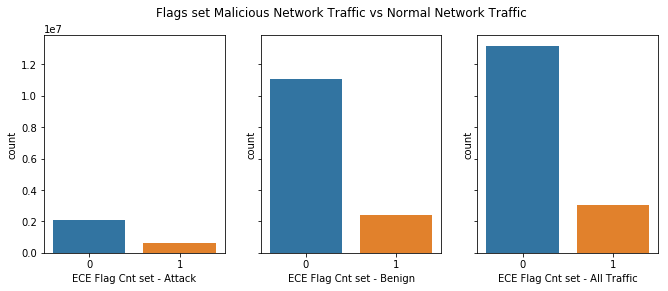

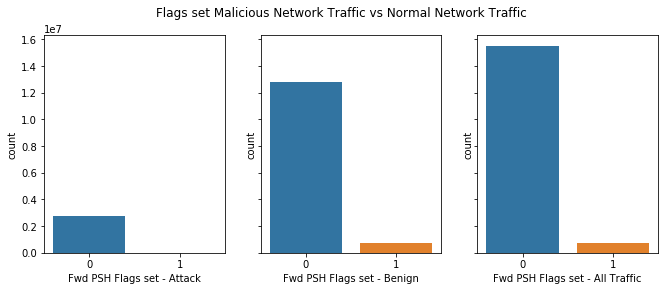

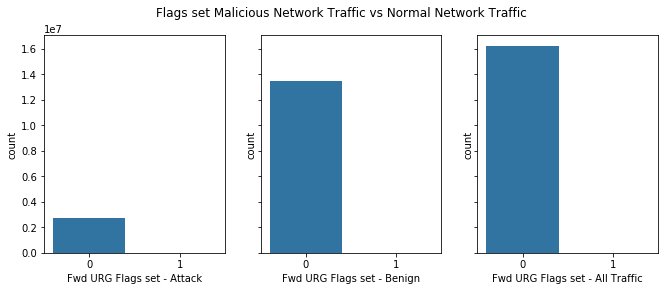

In [18]:
graph_flags()

In [19]:
# FIN Flag Cnt, SYN Flag Cnt, Fwd PSH Flags  - if set, probably benign
df['Benign Flag'] = ((df['FIN Flag Cnt'] == 1) | (df['SYN Flag Cnt'] == 1) | (df['Fwd PSH Flags'] == 1)).astype(int) 

In [20]:
df[['Benign Flag', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Fwd PSH Flags']].head()

,Benign Flag,FIN Flag Cnt,SYN Flag Cnt,Fwd PSH Flags
0,0,0,0,0
1,1,0,1,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [21]:
df[['Benign Flag', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Fwd PSH Flags']].tail()

,Benign Flag,FIN Flag Cnt,SYN Flag Cnt,Fwd PSH Flags
16232938,0,0,0,0
16232939,0,0,0,0
16232940,0,0,0,0
16232941,0,0,0,0
16232942,0,0,0,0


In [22]:
df.to_csv('model_basedf.csv', index=False)

In [ ]:
s3.Bucket(bucket).upload_file('model_basedf.csv', 'model_basedf.csv')